In [1]:
from typing import Tuple, Union, List
import numpy as np
import networkx as nx

from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Sampler
from qiskit.result import QuasiDistribution
from qiskit.utils import algorithm_globals
from qiskit.visualization import plot_histogram

In [2]:
def objective_value(x: np.ndarray, w: np.ndarray) -> float:
    """Compute the value of a cut.
    Args:
        x: Binary string as numpy array.
        w: Adjacency matrix.
    Returns:
        Value of the cut.
    """
    X = np.outer(x, (1 - x))
    w_01 = np.where(w != 0, 1, 0)
    return np.sum(w_01 * X)

def bitfield(n: int, L: int) -> List[int]:
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]  # [2:] to chop off the "0b" part

In [3]:
def get_operator(weight_matrix: np.ndarray) -> Tuple[SparsePauliOp, float]:
    r"""Generate Hamiltonian for the graph partitioning
    Notes:
        Goals:
            1 Separate the vertices into two set of the same size.
            2 Make sure the number of edges between the two set is minimized.
        Hamiltonian:
            H = H_A + H_B
            H_A = sum\_{(i,j)\in E}{(1-ZiZj)/2}
            H_B = (sum_{i}{Zi})^2 = sum_{i}{Zi^2}+sum_{i!=j}{ZiZj}
            H_A is for achieving goal 2 and H_B is for achieving goal 1.
    Args:
        weight_matrix: Adjacency matrix.
    Returns:
        Operator for the Hamiltonian
        A constant shift for the obj function.
    """
    num_nodes = len(weight_matrix)
    pauli_list = []
    coeffs = []
    shift = 0

    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(-0.5)
                shift += 0.5

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(1.0)
            else:
                shift += 1

    return SparsePauliOp(pauli_list, coeffs=coeffs), shift

In [4]:
def sample_most_likely(state_vector: Union[QuasiDistribution, Statevector]) -> np.ndarray:
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = bitfield(k, n)
    x.reverse()
    return np.asarray(x)

In [5]:
num_nodes = 4
w = np.array([[0., 1., 1., 0.],
              [1., 0., 1., 1.],
              [1., 1., 0., 1.],
              [0., 1., 1., 0.]])
G = nx.from_numpy_array(w)

{(0, 1): Text(0.7024844288825989, 0.3847779016941786, '1.0'),
 (0, 2): Text(0.634913831949234, 0.12277430109679699, '1.0'),
 (1, 2): Text(0.5660776197910309, 0.48680025339126587, '1.0'),
 (1, 3): Text(0.4158555418252945, 0.7546672821044922, '1.0'),
 (2, 3): Text(0.3482849448919296, 0.4926636815071106, '1.0')}

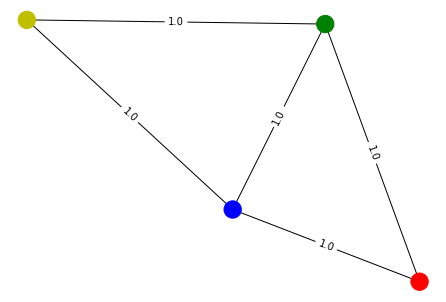

In [6]:
layout = nx.random_layout(G, seed=10)
colors = ['r', 'g', 'b', 'y']
nx.draw(G, layout, node_color=colors)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)

In [7]:
qubit_op, offset = get_operator(w)

In [8]:
sampler = Sampler()

algorithm_globals.random_seed = 10598

optimizer = COBYLA()
qaoa = QAOA(sampler, optimizer, reps=2)

result = qaoa.compute_minimum_eigenvalue(qubit_op)

x = sample_most_likely(result.eigenstate)

print(x)
print(f'Objective value computed by QAOA is {objective_value(x, w)}')

[1 0 1 0]
Objective value computed by QAOA is 3


In [9]:
Statevec = Statevector(list(result.eigenstate.values()))
counts = Statevec.probabilities_dict()

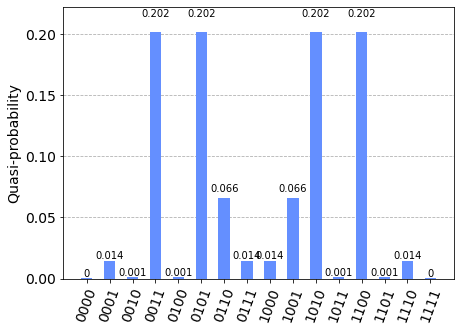

In [11]:
plot_histogram(counts)

{(0, 1): Text(0.7024844288825989, 0.3847779016941786, '1.0'),
 (0, 2): Text(0.634913831949234, 0.12277430109679699, '1.0'),
 (1, 2): Text(0.5660776197910309, 0.48680025339126587, '1.0'),
 (1, 3): Text(0.4158555418252945, 0.7546672821044922, '1.0'),
 (2, 3): Text(0.3482849448919296, 0.4926636815071106, '1.0')}

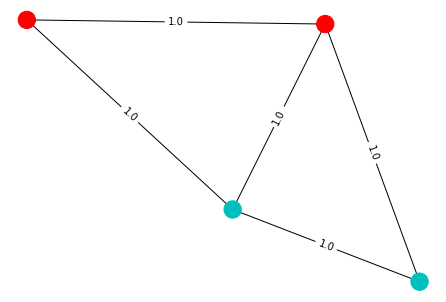

In [12]:
colors = ["r" if x[i] == 0 else "c" for i in range(num_nodes)]
nx.draw(G, layout, node_color=colors)
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)